In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import pandas as pd
import json
import re

from tqdm import tqdm
from collections import Counter
from random import sample
from scipy.optimize import curve_fit

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}


# 1) Red Erdos Renyi $G(N, p)$

In [2]:
def erdos_renyi_graph(N: int, p: float) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la probabilidad de enlazarse p.
    """

    random_matrix = np.random.random((N, N)) #Matriz de NxN de numeros aleatorios del 0 al 1.
    #Si el valor obtenido es menor que p, nos quedamos.
    threshold = np.where(random_matrix < p, 1, 0) #Para un valor de p-pequeño: "Era poco probable, pero pasó."

    #Nos quedamos con la parte superior, la transpuesta de la misma, y la diagonal para armar una A simétrica.
    A = np.triu(threshold, 1) + np.triu(threshold, 1).T
    return nx.from_numpy_array(A)


def erdos_renyi_m(N: int, approx_m: int) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la cantidad de enlaces.
    """
    p = 2*approx_m/(N*(N-1))
    return erdos_renyi_graph(N, p)


## a)

In [31]:
N = 10_000
m = 50_000
iters = 200

#Esto puede demorar bastante.
try:
    with open("1a.list", "rb") as f:
        m_vals = pickle.load(f)
except FileNotFoundError:
    m_vals = [len(list(erdos_renyi_m(N, m).edges())) for i in tqdm(range(iters))]
    with open("1a.list", "wb") as f:
        pickle.dump(m_vals, f)

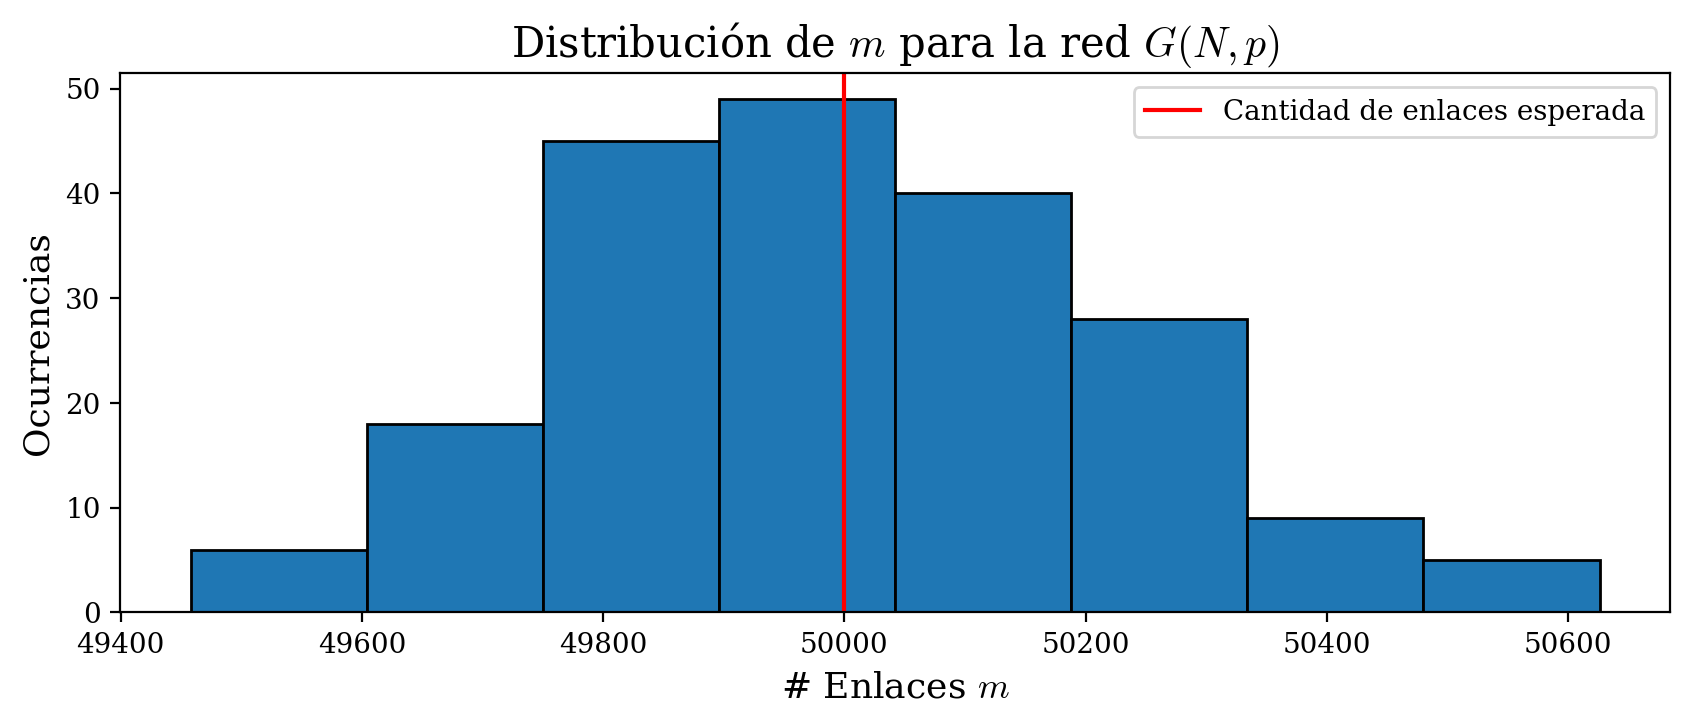

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

plt.hist(m_vals, bins=8, ec='k')
plt.axvline(m, color = "red", label="Cantidad de enlaces esperada")
plt.xlabel("# Enlaces $m$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de $m$ para la red $G(N, p)$", fontsize=15)
plt.legend()
plt.show()

## b)

In [30]:
N_arr = np.arange(100, 10_000, 500)
p = 0.001

try:
    with open("1b.list", "rb") as f:
        m_vals = pickle.load(f)

except FileNotFoundError:
    k_vals = []
    for N in tqdm(N_arr):
        G = erdos_renyi_graph(N, p)
        k_arr = list(dict(G.degree()).values())
        k_mean = np.mean(k_arr)
        k_vals.append(k_mean)

    with open("1b.list", "wb") as f:
        pickle.dump(k_vals, f)

Pendiente obtenida:  a = 0.001000095998038455 (Esperado: 0.001)
Ordenada al origen obtenida:  b = -0.03646517467416205 (Esperado: 0)


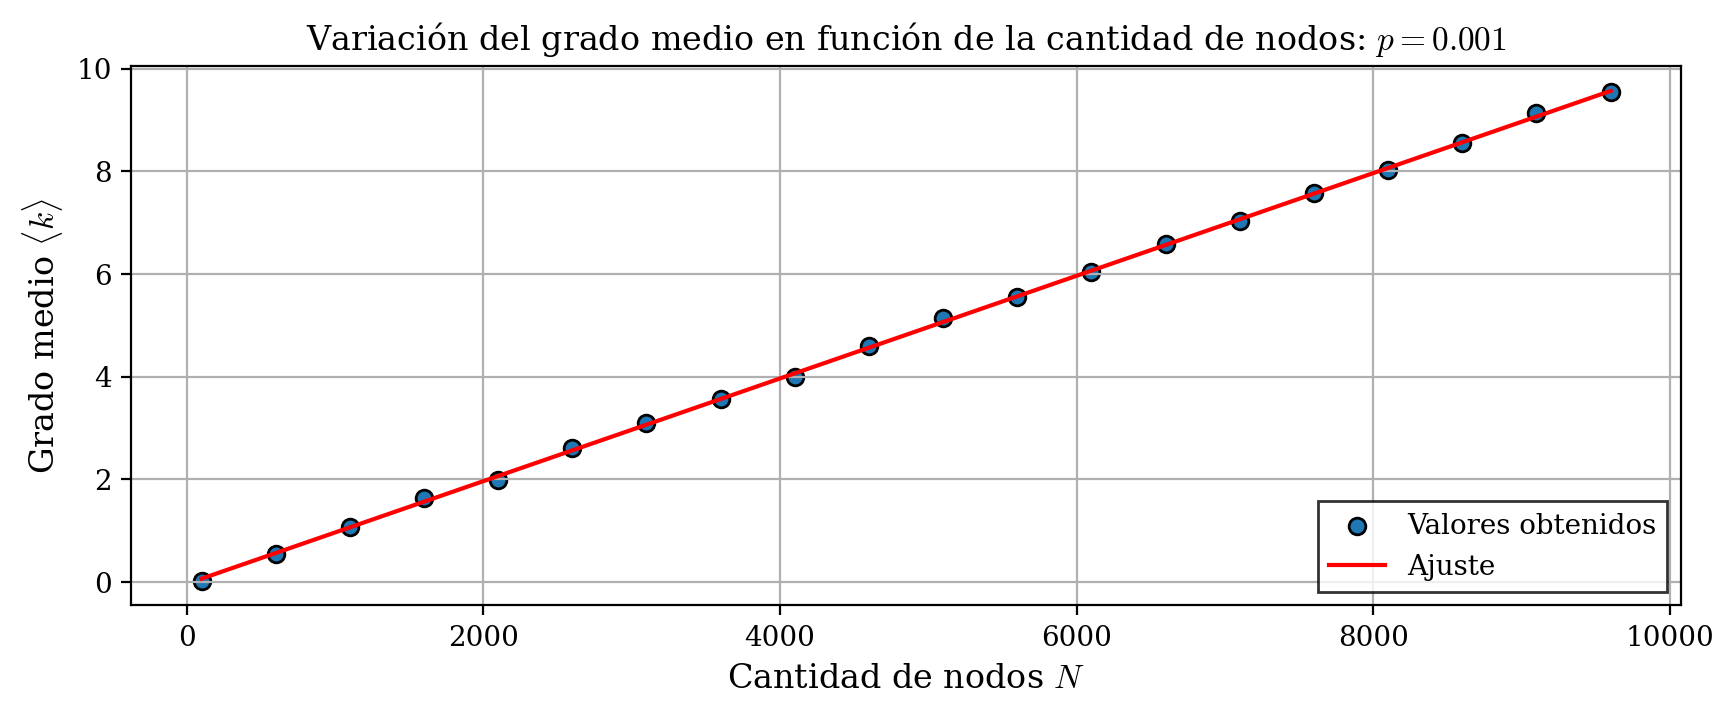

In [29]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, N_arr, k_vals)
a, b = popt

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

ax.scatter(N_arr, k_vals, ec = "black", label = "Valores obtenidos")
ax.plot(N_arr, lineal(N_arr, *popt), color="red", label="Ajuste")
ax.legend(loc="lower right", fancybox=False, edgecolor="black")
ax.set_xlabel("Cantidad de nodos $N$")
ax.set_ylabel(r"Grado medio $\langle k \rangle$")
ax.set_title(f"Variación del grado medio en función de la cantidad de nodos: ${p =}$")
ax.grid()

print(f"Pendiente obtenida: { a = } (Esperado: {p})")
print(f"Ordenada al origen obtenida: { b = } (Esperado: 0)")

# 2) Red aleatoria $G(N, k_0)$

In [3]:
def random_k0_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
        
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = sample(nodes, k0)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

# 3) Red Barabasi $\hat{G}(N, k_0)$

In [4]:
def barabasi_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)

    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        rand_vec = np.random.random(len(nodes))
        #k_vec = nx.to_numpy_array(G)@np.ones_like(rand_vec)  # grado vector

        degrees = dict(G.degree())
        sorted_degrees = dict(sorted(degrees.items())) #Grados (ordenados).
        
        k_vec = np.array(list(sorted_degrees.values()))

        p_vec = k_vec/np.sum(k_vec)
        link_to = rand_vec < p_vec
        
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, i) for i, t in enumerate(link_to) if t])

    return G

## a)

In [ ]:
N = 10_000
k0_arr = range(5, 15, 5)
k0_arr = np.array(k0_arr)
#Esto puede demorar bastante.
try:
    with open("3a.list", "rb") as f:
        m_vals = pickle.load(f)

except FileNotFoundError:
    m_vals = []
    for k0 in tqdm(k0_arr):
        G = barabasi_graph(N, k0)
        m = len(list(G.edges()))
        m_vals.append(m)

    with open("3a.list", "wb") as f:
        pickle.dump(m_vals, f)

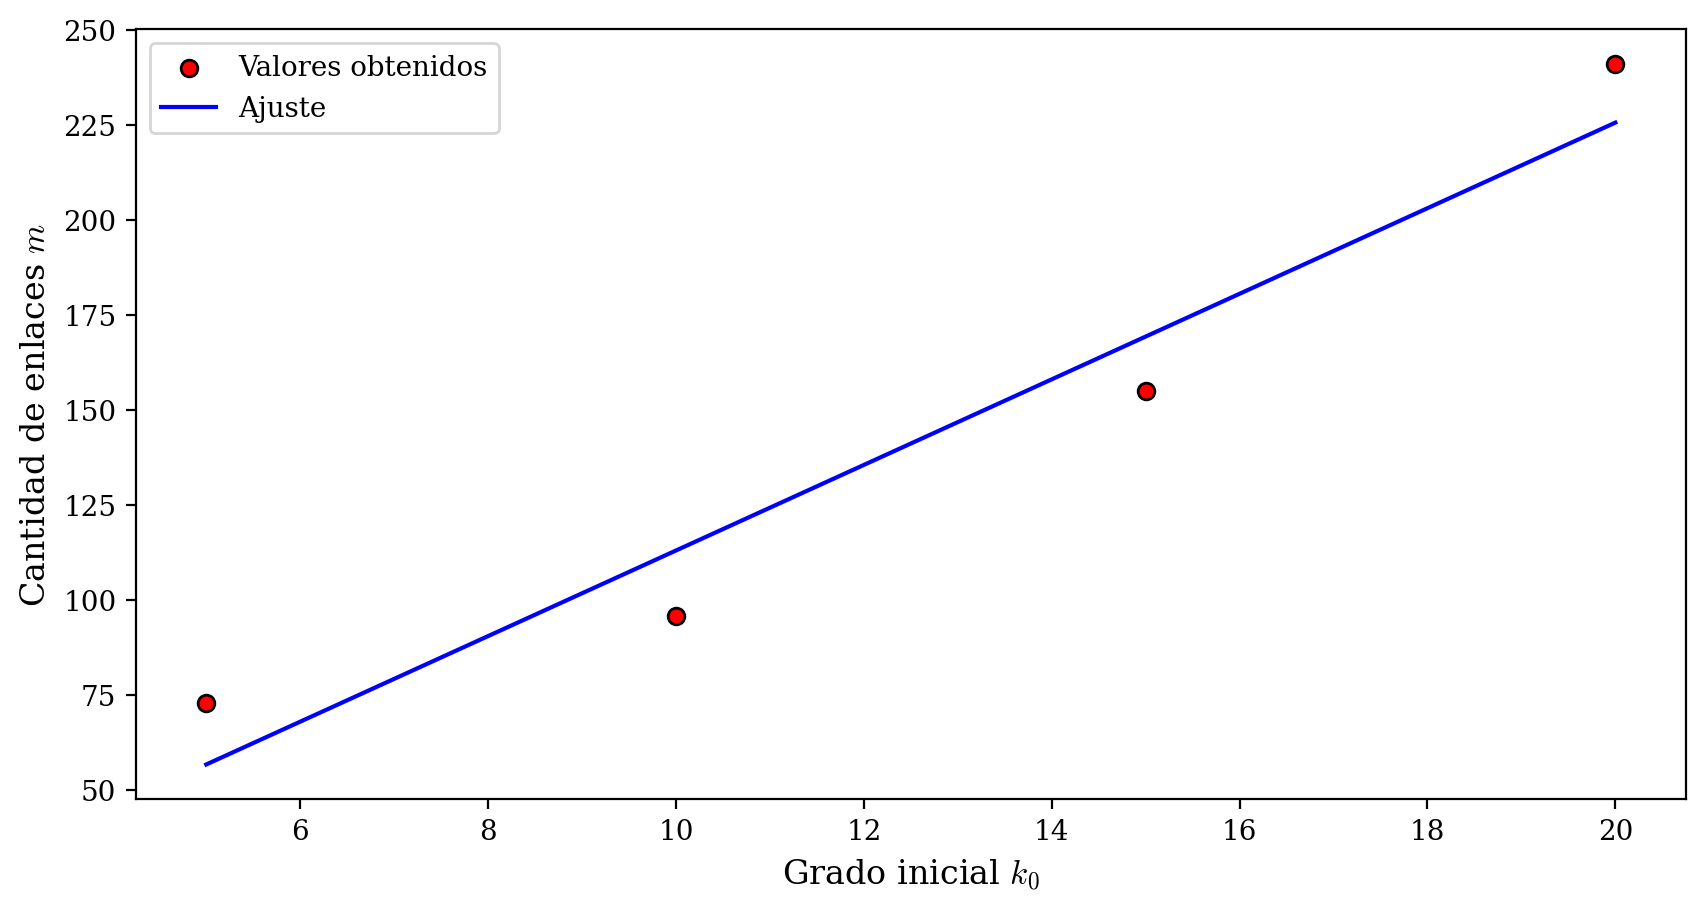

Pendiente obtenida: a = 11.260000000022378 (Esperado 10000)
Ordenada al origen obtenida: b = 0.4999999999989181 (Esperado 0)


In [80]:
lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, k0_arr, m_vals)
a, b = popt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.scatter(k0_arr, m_vals, color = "red", label = "Valores obtenidos", ec="black")
plt.plot(k0_arr, lineal(k0_arr, *popt), color="blue", label="Ajuste")
plt.xlabel("Grado inicial $k_0$")
plt.ylabel("Cantidad de enlaces $m$")
plt.legend()
plt.show()

print(f"Pendiente obtenida: {a = } (Esperado {N})")
print(f"Ordenada al origen obtenida: {b = } (Esperado 0)")

100%|██████████| 4/4 [00:00<00:00, 503.59it/s]

5
10
15
20


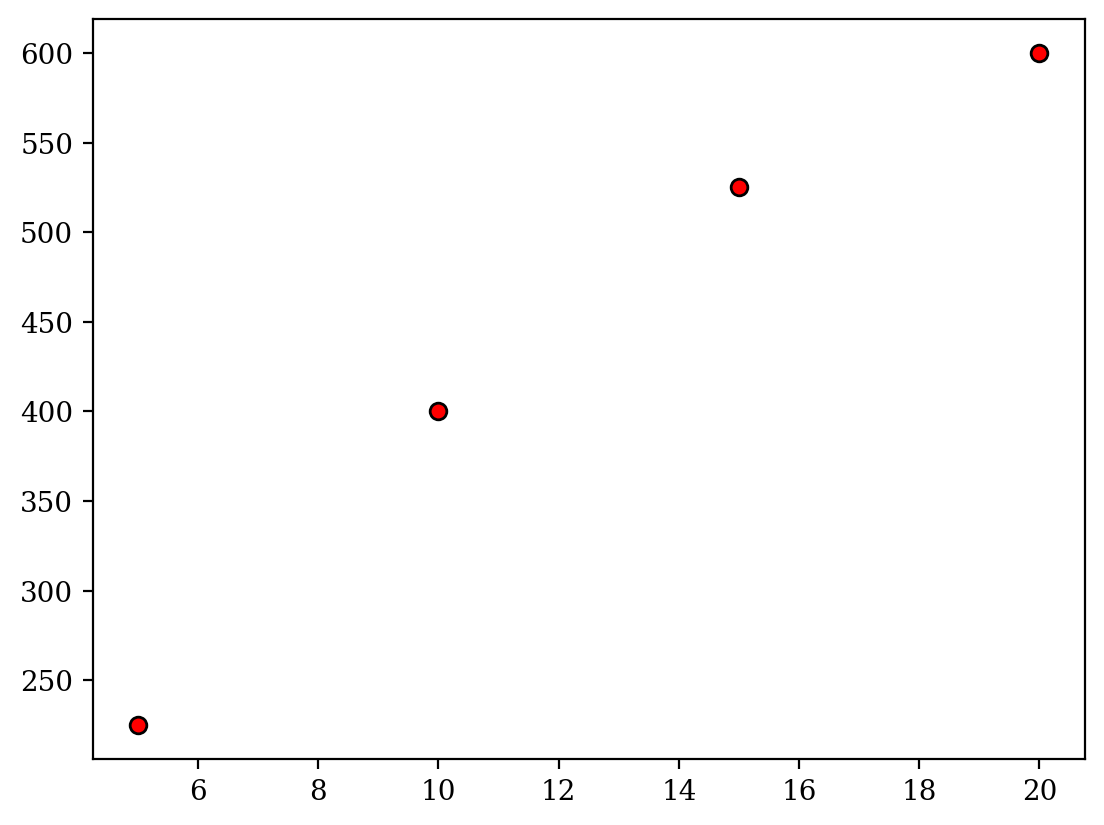

In [81]:
m_vals = []
for k0 in tqdm(k0_arr):
        print(k0)
        G = nx.barabasi_albert_graph(50, k0)
        m = len(list(G.edges()))
        m_vals.append(m)
plt.scatter(k0_arr, m_vals, color = "red", label = "Valores obtenidos", ec="black")

# 4)

In [5]:
def plot_degree_dist(G, ax = None):
    """
    Plot de la distribución de grados de este tipo de red.
    """

    degrees = dict(G.degree())
    degrees_dist = Counter(degrees.values())
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plt.scatter(degrees_dist.keys(), degrees_dist.values(), ec="black")
        return fig, ax
    else:
        ax.scatter(degrees_dist.keys(), degrees_dist.values(), ec="black")

def plot_random_distributions(G: nx.Graph, k02: int = 5, k03: int = 5, suptitle = None):
    fig, ax = plt.subplots(1, 4, figsize=(12, 4))

    N = len(list(G.nodes()))
    m = len(list(G.edges()))

    G_random1 = erdos_renyi_m(N, m)
    G_random2 = random_k0_graph(N, k02)
    G_random3 = nx.barabasi_albert_graph(N , k03)

    #Distribución real
    plot_degree_dist(G, ax[0])
    plot_degree_dist(G_random1, ax[1])
    plot_degree_dist(G_random2, ax[2])
    plot_degree_dist(G_random3, ax[3])
    
    for i in range(4):
        ax[i].set_xlabel("Grado $k$")
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
    ax[0].set_ylabel("Ocurrencias")
    
    ax[0].set_title("Distribución real")
    ax[1].set_title("Erdos Renyi")
    ax[2].set_title("Random $k_0$")
    ax[3].set_title("Barabasi")

    fig.suptitle(suptitle)



In [7]:
df_science = pd.read_csv("datasets/netscience_edgelist.txt", delimiter=";", header=None, names=["source", "target", "reference"])
df_science["reference"] = df_science["reference"].apply(lambda x: re.sub("'", "\"", x)) #Movemos a formato de JSON estandar
df_science["reference"] = df_science["reference"].apply(json.loads).apply(pd.Series)    #Cargamos a json y desempaquetamos el dict con el Series.

df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter="\t", header=None, names=["source", "target"])

df_internet = pd.read_csv("datasets/as-22july06_edgelist.txt", delimiter=" ", header=None, names=["source", "target", "val"])
df_internet.drop("val", axis=1, inplace=True)

dataframes = { 
    "Science": df_science,
    "Internet": df_internet,
    "Y2H": df_y2h,
}

### Creación de grafos
graph_science = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph())
graph_science_weighted = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph(), edge_attr = "reference")
weights_science = [i['reference'] for i in dict(graph_science_weighted.edges).values()]

graph_y2h = nx.from_pandas_edgelist(df_y2h,"source","target", create_using=nx.Graph())

graph_internet = nx.from_pandas_edgelist(df_internet,"source","target", create_using=nx.Graph())

dict_graph = { 
    "Science": graph_science,
    "Internet": graph_internet,
    "Y2H": graph_y2h,
}

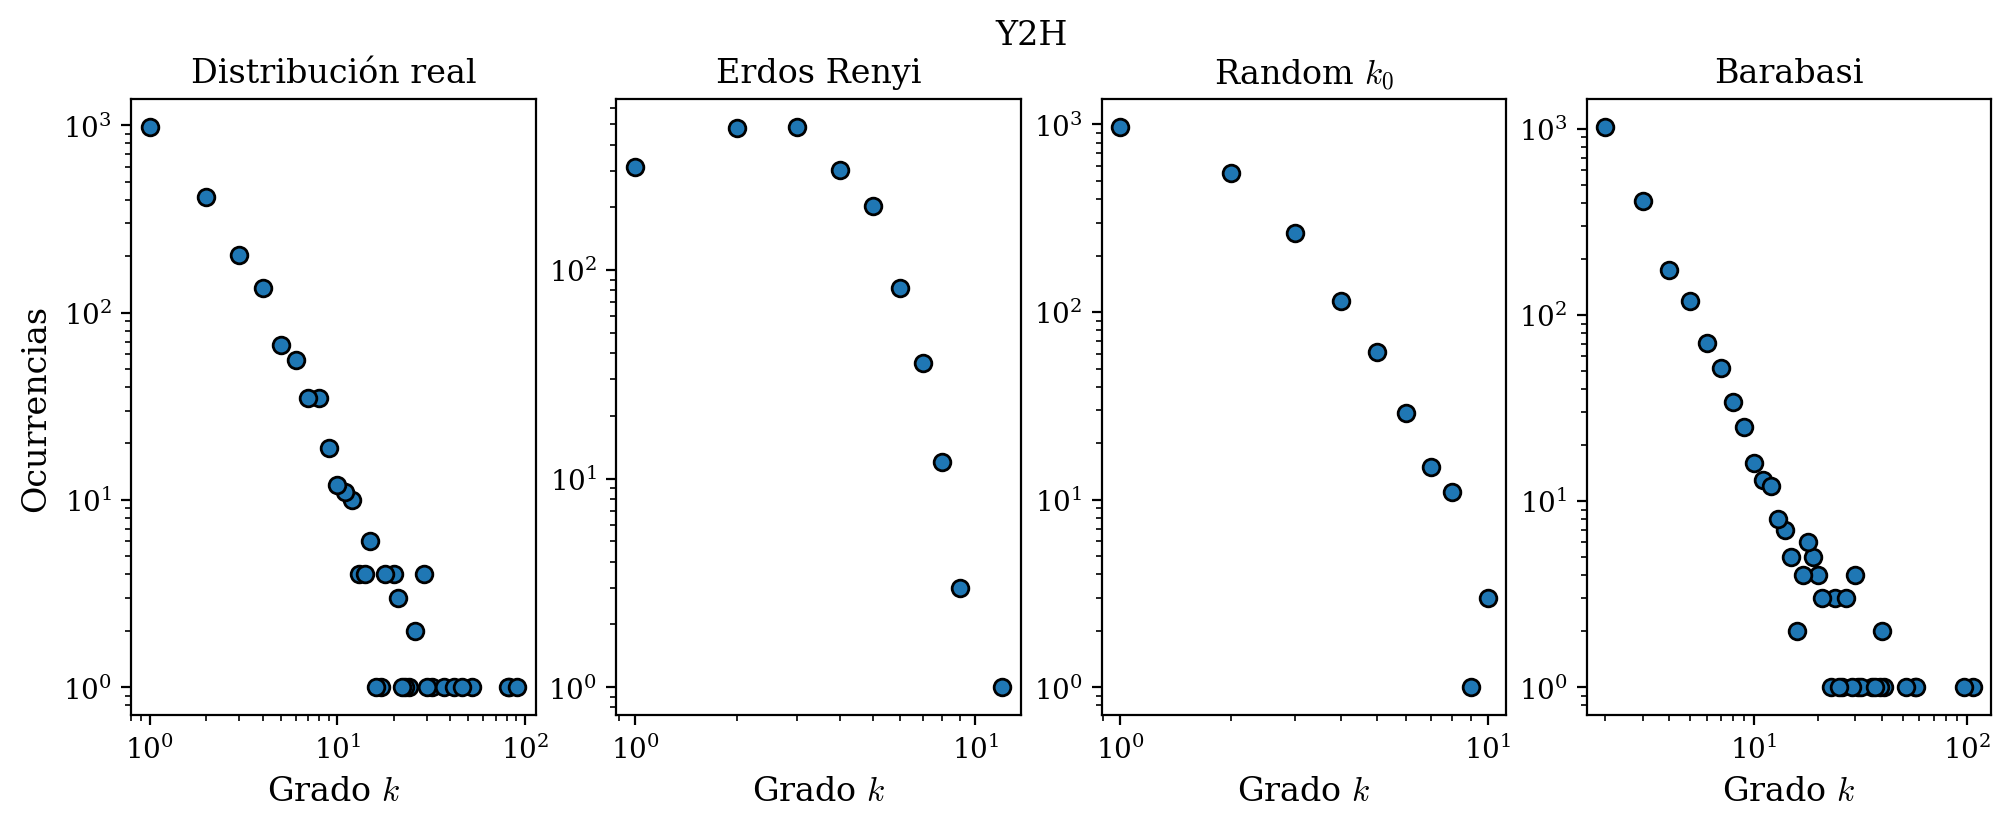

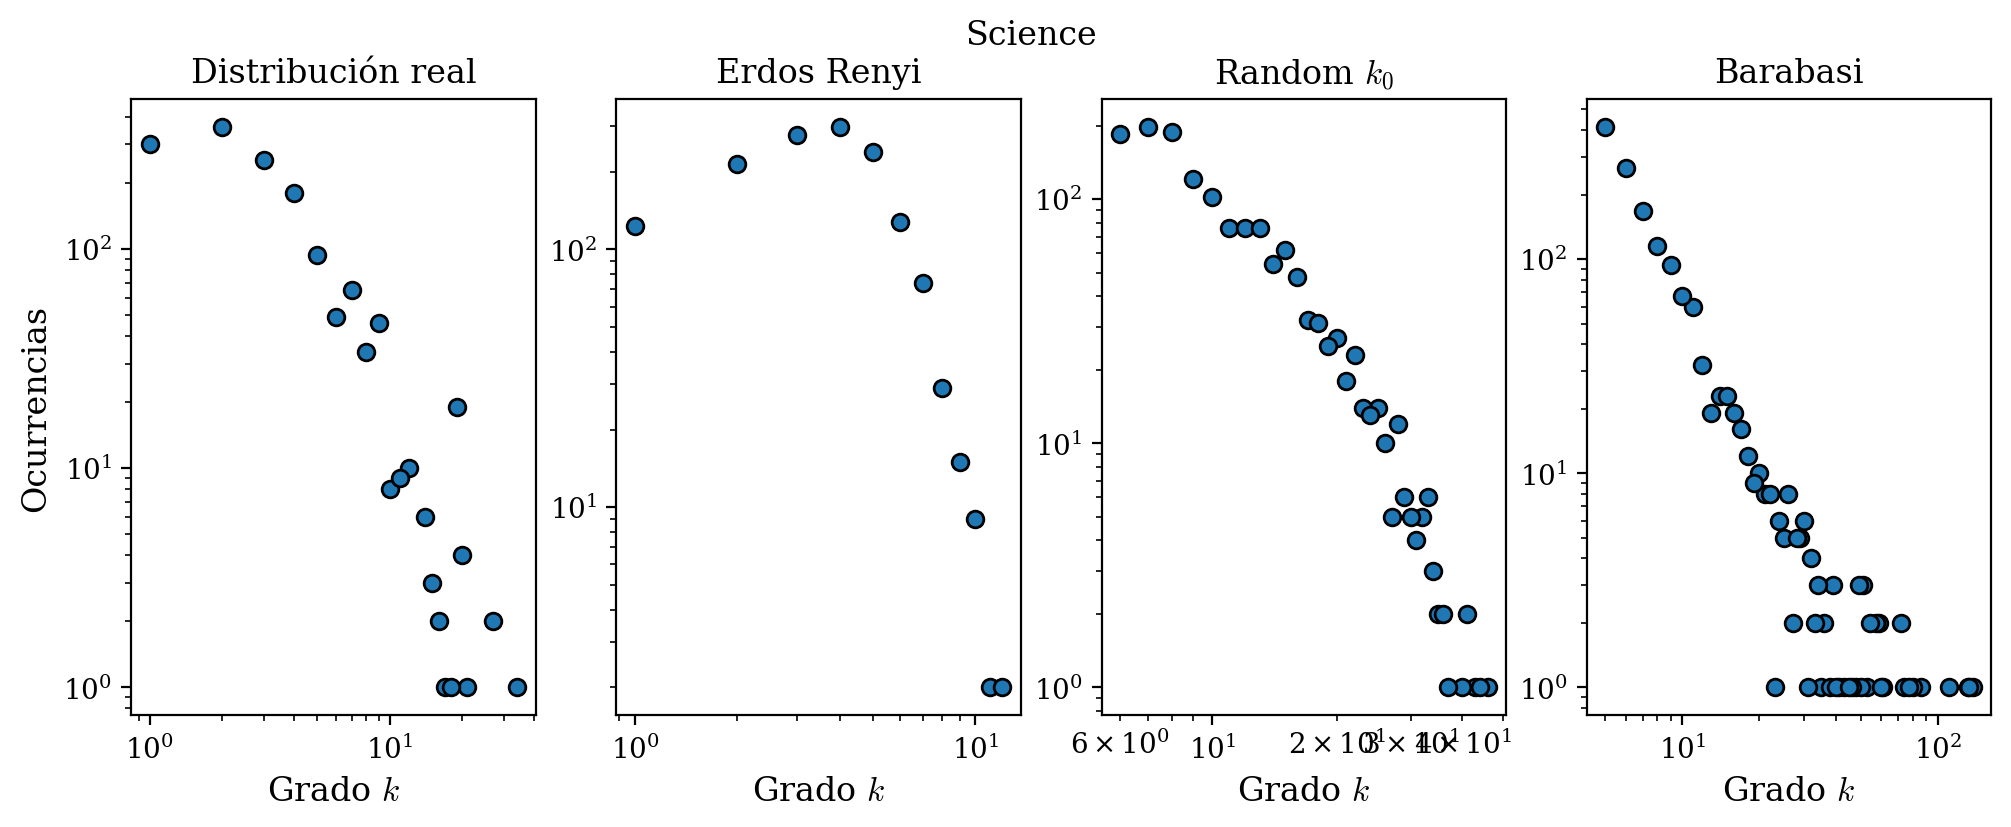

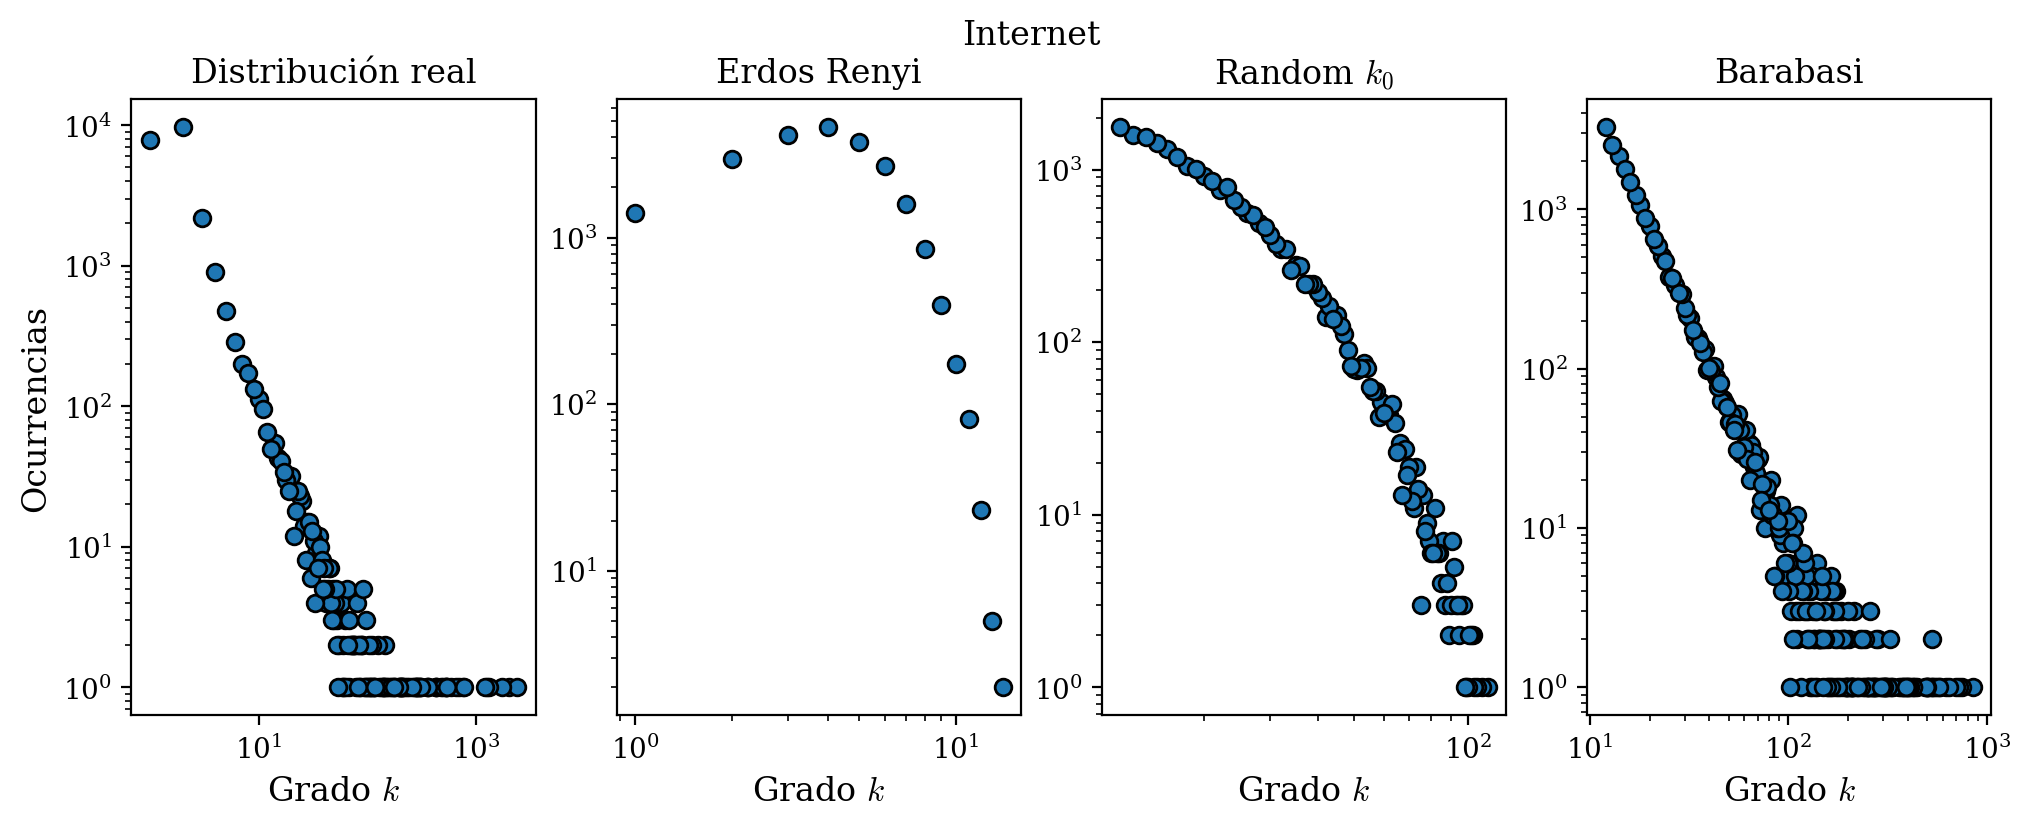

In [25]:
plot_random_distributions(dict_graph["Y2H"], k02 = 1, k03 = 2, suptitle="Y2H")
plot_random_distributions(dict_graph["Science"], k02 = 6, k03 = 5, suptitle="Science")
plot_random_distributions(dict_graph["Internet"], k02 = 12, k03 = 12, suptitle="Internet")

# Modelo configuracional